# 1D testing STDP model network

http://www.scholarpedia.org/article/Spike-timing_dependent_plasticity

STDP can be seen as a spike-based formulation of a Hebbian learning rule. 

Two thalamic inputs are sent to two cells (one for each) such that there's a small time gap between the two inputs.

Two cells are excitatory and the synapse from the first cells to the second is modelled with STDP.

In [1]:
# fileName

# run only with sPyNNaker

fileName = 'eg_testing-STDP-model-network'
savePath = f'../outputs/'
saveName = savePath+fileName
saveName

'../outputs/eg_testing-STDP-model-network'

In [2]:
try:
    import pyNN.spiNNaker as sim
except ModuleNotFoundError:
    import pyNN.brian2 as sim
    
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
import pandas as pd
import seaborn as sns
import time
import datetime
import json
import warnings
warnings.filterwarnings('ignore')
import python_utils as pu

%matplotlib inline

savePath = f'../outputs/' # remember to create the folder if not already present (mkdir ./notebooks/outputs)
dt_string = datetime.datetime.today().isoformat() # ISO8601 ! :-)
tag = dt_string 
saveName = f'{savePath}{fileName}-{tag}'
print(saveName)
PARS={}


../outputs/eg_testing-STDP-model-network-2023-11-27T19:47:25.658297


In [3]:
# simulation settings

sim.setup(
        timestep=1, # [ms]
        min_delay=1, # [ms]
        max_delay=100) # [ms]

simtime = 150 # [ms+]



2023-11-27 19:47:25 INFO: Read cfg files: /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg, /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg, /home/bbpnrsoa/.spynnaker.cfg
2023-11-27 19:47:25 INFO: Will search these locations for binaries: /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/common_model_binaries : /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/model_binaries
2023-11-27 19:47:25 WARNING: /home/bbpnrsoa/CNT-2024/notebooks/reports has 9 old reports that have not been closed
2023-11-27 19:47:25 INFO: Setting time scale factor to 10.
2023-11-27 19:47:25 INFO: Setting machine time step to 1000 micro-seconds.


['/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/bbpnrsoa/.spynnaker.cfg']


## make the network

In [4]:
# define make_pop

pops = {}

pops['pre'] = sim.Population(
                        1, # one cell in each cell model
                        sim.IF_cond_exp(),
                        #cellparams=sim.IF_curr_exp.default_initial_values, # std pars used
                        structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                        label='pre',
                        )
                        
pops['post'] = sim.Population(
                        1, # one cell in each cell model
                        sim.IF_cond_exp(),
                        #cellparams=sim.IF_curr_exp.default_initial_values, # std pars used
                        structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                        label='post',
                        )

pops['pre'].record(['spikes', 'v', 'gsyn_exc', 'gsyn_inh'])
pops['post'].record(['spikes', 'v', 'gsyn_exc', 'gsyn_inh'])

pops.keys()

dict_keys(['pre', 'post'])

## make the thalamic input stimulus

In [5]:
pops['thalamus-pre'] = sim.Population(1, 
                            sim.SpikeSourceArray([30, 40, 50, 60, ]),
                            structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                            )    

pops['thalamus-post'] = sim.Population(1, 
                             sim.SpikeSourceArray([32, 42, 52, 62, ]),
                             structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0))

pops['thalamus-post'].record('spikes')
pops['thalamus-pre'].record('spikes')


pops.keys()

dict_keys(['pre', 'post', 'thalamus-pre', 'thalamus-post'])

## make learning rule between pre and post syn cells

In [6]:
timing = sim.SpikePairRule(tau_plus=10.0, 
                           tau_minus=1.0, 
                           A_plus=0.5, 
                           A_minus=0.5)

weight = sim.AdditiveWeightDependence(w_max=5, w_min=0.0) # range of learnig 

starting_weight = 0 #0.1 # uS
projs = {}
projs['pre', 'post'] = sim.Projection(pops['pre'], pops['post'], 
                                      sim.OneToOneConnector(), 
                                      sim.STDPMechanism(
                                          timing_dependence=timing, 
                                          weight_dependence=weight, 
                                          weight=starting_weight, 
                                          delay=5.0))

projs.keys()

dict_keys([('pre', 'post')])

## make the thalamic - pops projections

In [7]:
projs['thalamus-pre', 'pre'] = sim.Projection(
                                    pops['thalamus-pre'],
                                    pops['pre'],
                                    sim.OneToOneConnector(),
                                    synapse_type=sim.StaticSynapse(weight=5),#, delay=None),
                                    receptor_type = 'excitatory',
                                    space = space.Space(axes = 'x'),
                                    label=None,
                                )


projs['thalamus-post', 'post'] = sim.Projection(
                                    pops['thalamus-post'],
                                    pops['post'],
                                    sim.OneToOneConnector(),
                                    synapse_type=sim.StaticSynapse(weight=5),#, delay=1.0),
                                    receptor_type = 'excitatory',
                                    space = space.Space(axes = 'x'),
                                    label=None,
                                )



projs.keys()

dict_keys([('pre', 'post'), ('thalamus-pre', 'pre'), ('thalamus-post', 'post')])

## run the simulation

In [8]:
# simulation run

tic = time.time()
sim.run(simtime)
toc = time.time() - tic
print(toc)

2023-11-27 19:47:25 INFO: Starting execution process
2023-11-27 19:47:25 INFO: Simulating for 150 1.0ms timesteps using a hardware timestep of 10000us
Adding Splitter selectors where appropriate
|0%                          50%                         100%|
2023-11-27 19:47:25 INFO: Time 0:00:00.013117 taken by SpynnakerSplitterSelector
Adding delay extensions as required
|0%                          50%                         100%|
2023-11-27 19:47:25 INFO: Time 0:00:00.012069 taken by DelaySupportAdder
2023-11-27 19:47:28 INFO: Time 0:00:03.185912 taken by SpallocMaxMachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2023-11-27 19:47:40 INFO: Time 0:00:11.081810 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2023-11-

71.70865416526794


## save and get results

In [9]:
stateVars = {}
for pop in pops.keys():
    for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
        pops[pop].write_data(f'{saveName}-{recording}.pkl')
        stateVars[pop]=pops[pop].get_data()

stateVars.keys()
results = pu.recover_results(stateVars)
results.keys()

Getting spikes for pre
|0%                          50%                         100%|
Getting v for pre
|0%                          50%                         100%|
Getting gsyn_exc for pre
|0%                          50%                         100%|
Getting gsyn_inh for pre
|0%                          50%                         100%|
Getting spikes for pre
|0%                          50%                         100%|
Getting v for pre
|0%                          50%                         100%|
Getting gsyn_exc for pre
|0%                          50%                         100%|
Getting gsyn_inh for pre
|0%                          50%                         100%|
Getting spikes for pre
|0%                          50%                         100%|
Getting v for pre
|0%                          50%                         100%|
Getting gsyn_exc for pre
|0%                          50%                         100%|
Getting gsyn_inh for pre
|0%                          50%  

pre
v
gsyn_exc
gsyn_inh
post
v
gsyn_exc
gsyn_inh
thalamus-pre
thalamus-post


dict_keys([('pre', 'v'), ('pre', 'gsyn_exc'), ('pre', 'gsyn_inh'), ('pre', 'spikes'), ('post', 'v'), ('post', 'gsyn_exc'), ('post', 'gsyn_inh'), ('post', 'spikes'), ('thalamus-pre', 'spikes'), ('thalamus-post', 'spikes')])

## check the spikes

Text(27.125, 0.5, 'cells ID')

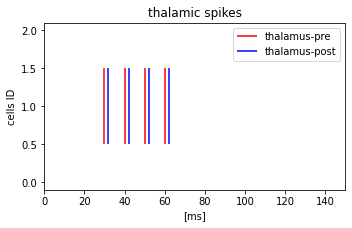

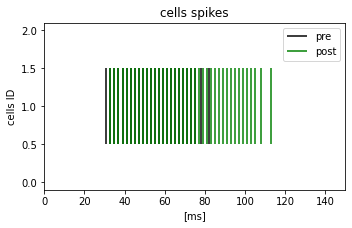

In [10]:
fig, axes = plt.subplots(1,1)
fig.tight_layout(pad=5)
axes_list = fig.axes


axes_list[0].eventplot(results['thalamus-pre', 'spikes'], label='thalamus-pre', color='r')
axes_list[0].eventplot(results['thalamus-post', 'spikes'], label='thalamus-post', color='b')
axes_list[0].set_title('thalamic spikes')
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('cells ID')
axes_list[0].set_xlim(0,simtime)
#axes_list[0].set_ylim(0,2)
axes_list[0].legend()


fig, axes = plt.subplots(1,1)
fig.tight_layout(pad=5)
axes_list = fig.axes
axes_list[0].eventplot(results['pre', 'spikes'], label='pre', color='k')
axes_list[0].eventplot(results['post', 'spikes'], label='post', color='g')
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_title('cells spikes')
axes_list[0].set_xlim(0,simtime)
axes_list[0].legend()
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('cells ID')




## check the voltage signature

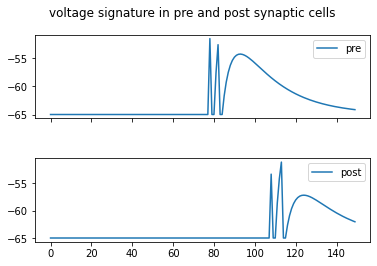

In [11]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)#, figsize=(11,7))
fig.tight_layout(pad=3)
fig.suptitle('voltage signature in pre and post synaptic cells')

axes_list = fig.axes
for idx, syn in enumerate(['pre', 'post']):
    axes_list[idx].plot(results[syn, 'v'], label=str(syn))
    axes_list[idx].legend()

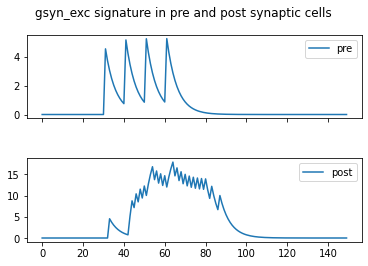

In [12]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)#, figsize=(11,7))
fig.tight_layout(pad=3)
fig.suptitle('gsyn_exc signature in pre and post synaptic cells')

axes_list = fig.axes
idx = 0
for idx, syn in enumerate(['pre', 'post']):
    axes_list[idx].plot(results[syn, 'gsyn_exc'], label=str(syn))
    axes_list[idx].legend()

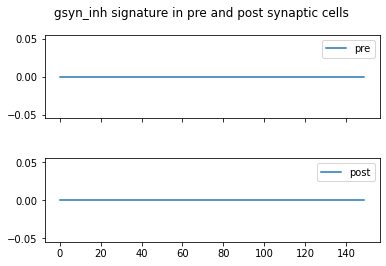

In [13]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)#, figsize=(11,7))
fig.tight_layout(pad=3)
fig.suptitle('gsyn_inh signature in pre and post synaptic cells')

axes_list = fig.axes
idx = 0
for idx, syn in enumerate(['pre', 'post']):
    axes_list[idx].plot(results[syn, 'gsyn_inh'], label=str(syn))
    axes_list[idx].legend()

## check the STDP between pre and post cells

In [14]:
projs.keys()
#projs['pre', 'post'].get(['source', 'target', 'weight', 'delay'], "list")
print('starting weight pre stdp: ', starting_weight, ' [uS]')
print('final weight after stdp: ', projs['pre', 'post'].getWeights(), ' [uS]')


2023-11-27 19:48:39 WARNING: getWeights is deprecated.  Use get('weight') instead
Getting synaptic data between pre and post
|0%                          50%                         100%|

starting weight pre stdp:  0  [uS]
final weight after stdp:  [5.]  [uS]


In [15]:

# the weight between pre and post neuron was set to zero before the learning, now it's ..

## end the simulations

In [16]:
sim.end()

# task1: on thalamus input spike times
- test different interspike timing <br>
  e.g., <br>
    a=np.arange(0,100,10) for the thalamus-pre <br>
    a+15 for the thalamus post <br>
    
- test only one spike source eliciting the pre synaptic cell<br>


# task2: on STDP mechanism
- try to change the parameter inside the SpikePairRule
- create the STDP "weights as function of delta time" plot
- check: http://www.scholarpedia.org/article/Spike-timing_dependent_plasticity



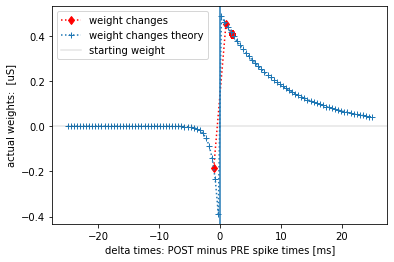

In [17]:
# start from this snap

SPIKES={}
for feat in ['pre', 'post']:
    VAR=results[feat, 'spikes']
    for k in range(len(VAR)):
        SPIKES[feat]=[]
        SPIKES[feat].append(np.array(list(VAR[k])).T,)

post=SPIKES['post'][0][0:len(SPIKES['pre'][0])],
pre=SPIKES['pre'][0]

x=np.sort(post-pre)
xTh=np.linspace(-25, 25, 100)

A_plus=0.5
A_minus=0.5
tau_plus=10
tau_minus=1
W_x_plus = A_plus*np.exp(-x[x>0]/tau_plus)
W_x_minus = - A_minus*np.exp(x[x<0]/tau_minus)

W_x_plus_th = A_plus*np.exp(-xTh[xTh>0]/tau_plus)
W_x_minus_th = - A_minus*np.exp(xTh[xTh<0]/tau_minus)

plt.plot(x[0], np.array(list(W_x_minus)+list(W_x_plus)), ':d', c='r', label='weight changes')
plt.plot(xTh, np.array(list(W_x_minus_th)+list(W_x_plus_th)), ':+', label='weight changes theory')

#plt.axhline(y=0)
plt.axvline(x=0)

plt.xlabel('delta times: POST minus PRE spike times [ms]')
plt.ylabel('actual weights:  [uS]')
plt.axhline(y=starting_weight, color='k', alpha=.1, label='starting weight')
plt.legend()